##### Версия 0.1 -- Март 2014

# Слой источников

Слой источников это бесконечная цепочка источников, выстроенных в одну линию. Вы уже делали что-то похожее — слой, составленный из бесконечной [цепочки вихрей](05_Lesson05_InfiniteRowOfVortices.ipynb).

Убедитесь, что вы изучили [7-е занятие *AeroPython*](07_Lesson07_methodOfImages.ipynb), посвященное методу зеркальных отражений и научились пользоваться классами в Питоне. С этого момента классы будут нас постоянно сопровождать!

Начнем, как мы уже много раз делали, с импорта библиотек и создания расчетной сетки.

In [1]:
import numpy
import math
from matplotlib import pyplot
# помещаем графику внутрь блокнота
%matplotlib inline

In [2]:
N = 100                               # Число точек в каждом направлении
x_start, x_end = -1.0, 1.0            # граница по x
y_start, y_end = -1.5, 1.5            # граница по y
x = numpy.linspace(x_start, x_end, N)    # вычисляем одномерный массив x
y = numpy.linspace(y_start, y_end, N)    # вычисляем одномерный массив y
X, Y = numpy.meshgrid(x, y)              # создаем расчетную сетку

Добавим также равномерный поток со скоростью $U_\infty = 1$, параллельный горизонтальной оси. Массивы `u_freestream` и `v_freestream` содержат значения компонент вектора скорости равномерного потока в узлах расчетной сетки. Давайте заполним их:

In [3]:
u_inf = 1.0     # скорость набегающего потока

# рассчитываем компоненты вектора скорости набегающего потока
u_freestream = u_inf * numpy.ones((N, N), dtype=float)
v_freestream = numpy.zeros((N, N), dtype=float)

### Конечное число источников, расположенных на линии

Сперва рассмотрим конечное число источников, расположеных вдоль вертикальной линии, по нормали к потоку. Линии тока будут истекать из каждого источника и отклоняться потоком, набегающим из бесконечности.

С вычислительной точки зрения, конечное число источников может быть представлено как одномерный массив, состоящий из объектов класса `Source`. У этого класса должны быть атрибуты, отвечающие за интенсивность источника — `strength`, и его местоположение (`x`,`y`). Методы класса должны вычислять компоненты скорости и функцию тока в узлах заданной расчетной сетки, и, конечно, у него должен быть *конструктор*:

In [4]:
class Source:
    """
    Contains information related to a source/sink.
    """
    def __init__(self, strength, x, y):
        """
        Sets the location and strength of the singularity.
        
        Parameters
        ----------
        strength: float
            Strength of the source/sink.
        x: float
            x-coordinate of the source/sink.
        y: float
            y-coordinate of the source/sink.
        """
        self.strength = strength
        self.x, self.y = x, y

    def velocity(self, X, Y):
        """
        Computes the velocity field generated by the source/sink.
        
        Parameters
        ----------
        X: 2D Numpy array of floats
            x-coordinate of the mesh points.
        Y: 2D Numpy array of floats
            y-coordinate of the mesh points.
        """
        self.u = self.strength/(2*math.pi)*(X-self.x)/((X-self.x)**2+\
                                                       (Y-self.y)**2)
        self.v = self.strength/(2*math.pi)*(Y-self.y)/((X-self.x)**2+\
                                                       (Y-self.y)**2)

    def stream_function(self, X, Y):
        """
        Computes the stream-function generated by the source/sink.
        
        Parameters
        ----------
        X: 2D Numpy array of floats
            x-coordinate of the mesh points.
        Y: 2D Numpy array of floats
            y-coordinate of the mesh points.
        """
        self.psi = self.strength/(2*math.pi)*numpy.arctan2((Y-self.y), \
                                                           (X-self.x))

Теперь вы увидите, какая полезная штука — классы! Мы воспользуемся созданным классом `Source` для создания источников, из которых будет состоять рассматриваемый слой. Выберем число `N_sources` и вызовем конструктор класса столько раз, при этом изменяя координату $y$ в положении источника. Затем вычислим скорости, наведенные источниками, используя соответствующую функцию.

In [5]:
N_sources = 11                      # количество источников
strength = 5.0                      # суммарная интенсивность источников
strength_source = strength/N_sources # интенсивность единичного источника
# положение источников по горизонтали (одномерный массив)
x_source = numpy.zeros(N_sources, dtype=float) 
# положение источников по вертикали (одномерный массив)
y_source = numpy.linspace(-1.0, 1.0, N_sources)  

# создаем линию из источников (Numpy массив объектов типа Source)
sources = numpy.empty(N_sources, dtype=object)
for i in range(N_sources):
    sources[i] = Source(strength_source, x_source[i], y_source[i])
    sources[i].velocity(X, Y)

# суперпозиция всех источников и набегающего потока
u = u_freestream.copy()
v = v_freestream.copy()
for source in sources:
    u += source.u
    v += source.v

Обратите внимание, что переменная `sources` обозначает массив NumPy, содержащий набор элементов одного типа. Какого? Вы, вероятно, уже привыкли к массивам чисел, но можно также создавать массивы объектов любого типа, в нашем случае — объектов класса `Source`.

Мы создаем пустой массив numpy с именем `sources`, и говорим Python, что его элементами будут объекты, которые не являются встроенным типом данных, как `int` или `float`. Число элементов массива равно `N_sources`.

В первом цикле мы заполняем массив, вызывая *конструктор* класса `Source` для каждого элемента. Кроме этого мы еще и вычисляем поле скоростей, наведенное каждым источником, испольлуя метод `velocity()`. Во втором цикле, создав предварительно массивы для компонент скоростей `u` и `v` и инициализировав их компонентами набегающего потока, мы прибалвляем к ним вклад от скоростей источников.

Окончательная картина линий тока описывает  суперпозицию равномерного потока и `N_sources` источников одинаковой интенсивности `strength_source`, равномерно распределенных вдоль вертикальной линии по нормали к потоку. На рисунке мы также обозначим красными точками положение источников и а черным ромбом — положение точки торможения, которая определяется как точка с наименьшим значением абсолютной величины скорости.

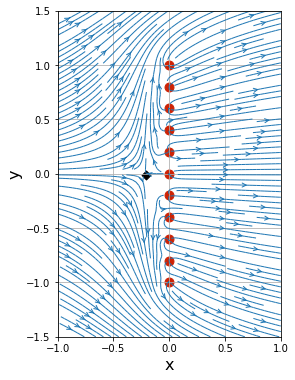

In [6]:
# рисуем линии тока
size = 4
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.streamplot(X, Y, u, v,
                  density=2, linewidth=1, arrowsize=1, arrowstyle='->')
# рисуем источники
pyplot.scatter(x_source, y_source,
               color='#CD2305', s=80, marker='o')
# вычисляем величину скорости и индексы точки торможения
# внимание: за точку торможения принимается точка,
# в которой скорость минимальна
magnitude = numpy.sqrt(u**2 + v**2)
j_stagn, i_stagn = numpy.unravel_index(magnitude.argmin(),
                                       magnitude.shape)
# рисуем точку торможения
pyplot.scatter(x[i_stagn], y[j_stagn],
               color='black', s=40, marker='D')
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end);

Попробуйте изменить интенсивность и положение источников. При каком минимальном значении суммарной интенсивности источников разделительная линия тока ($\psi = 0$) приближается к ним вплонтную?

### Бесконечная линия источников

По определению, *слой источников* это набор расположенных вплотную источников бесконечно малой и равной интенсивности, распределенных вдоль заданной кривой.

Обозначим погонную интенсивность (или интенсивность на единицу длины) как $\sigma = \sigma(s)$, где $s$ — параметр кривой.

Вспомним, что интенсивность одиночного источника это его удельный расход.
Тогда $\sigma$ является удельным расходом на единицу длины в направлении $s$. А $\sigma ds$ — это интенсивность бесконечно малого отрезка $ds$ слоя источников.  Этот отрезок настолько мал, что его можно рассматривать как отдельный источник интенсивности $\sigma ds$

Согласно этим рассуждениям, функция тока в точке $\left(r,\theta\right)$ от такого источника будет равна

$$d\psi\left(r,\theta\right) = \frac{\sigma ds}{2\pi} \theta$$

Интегрируя вдоль $s$, найдем функцию тока слоя источников:

$$\psi\left(r,\theta\right) = \frac{\sigma}{2\pi}\int_{\text{sheet}}\theta\left(s\right)ds$$

В предыдущем разделе мы рассмотрели конечное распределение источников вдоль вертикальной прямой. Аналогично, функция тока вертикального слоя источников, расположенного в $x=0$ между точками $y_{\text{min}}$ и $y_{\text{max}}$ в декартовой системе координат записывается в виде:

$$\psi\left(x,y\right) = \frac{\sigma}{2\pi}\int_{y_{\text{min}}}^{y_{\text{max}}} \tan^{-1}\left(\frac{y-\xi}{x}\right)d\xi$$

А компоненты скорости – 

$$u\left(x,y\right) = \frac{\sigma}{2\pi} \int_{y_{\text{min}}}^{y_{\text{max}}} \frac{x}{x^2+\left(y-\xi\right)^2}d\xi$$

$$v\left(x,y\right) = \frac{\sigma}{2\pi} \int_{y_{\text{min}}}^{y_{\text{max}}} \frac{y-\xi}{x^2+\left(y-\xi\right)^2}d\xi$$

#### Используем SciPy

Для определения скоростей нам нужно вычислить два интеграла, полученные выше. Ну, приехали, скажете вы. Вычислять интегралы это не модно. Без паники! У нас есть SciPy: набор мощных математических алгоритмов и функций. В нем имеется модуль [`integrate`](http://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html), базовый набор функций для научных вычислений, включающий простейшее интегрирование, квадратурные формулы и реализации методов численного интегрирования для обыкновенных дифференциальных уравнений. Насколько это полезно?

Давайте импортируем нужный модуль из SciPy:

In [7]:
from scipy import integrate

Мы воспользуемся функцией [`quad(func,a,b)`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html#scipy.integrate.quad) модуля `integrate` для вычисления значения определенного интеграла функции одной переменной на отрезке:

$$I=\int_a^b f(x)\ {\rm d}x$$

Нужно, чтобы первым аргументом функции `quad` была питоновская функция... Вы уже знаете, как создавать функцию в Python  при помощи ключевого слова `def`, а теперь вы узнаете, как это сделать, используя выражение `lambda`. Зачем, вы спросите, нужны два спососба для одного и того же действия? Ответ на этот вопрос довольно тонкий, а на эту тему написан не один пост в блогах! (Ссылки последуют)

Если коротко, функция, создаваемая при помощи `lambda`-выражения задается одним выражением, которое возвращает какое-либо значение (при этом `return` не используется!). Такую функцию часто называют "анонимной", так как ей не нужно давать имя.

Давайте разберемся, как можно использовать `lambda`-выражения для интегрирования математических функций. Предположим, что мы хотм вычислить интеграл  $f:x\rightarrow x^2$ от $0$ до $1$. Вы же можете это сделать вручную, правда? 

Получится $\frac{1}{3}$.

Чтобы использовать функцию `quad()`, мы подаем ей в качестве первого аргумента выражение `lambda x : x**2`:

In [8]:
print(integrate.quad(lambda x: x**2, 0.0, 1.0))

(0.33333333333333337, 3.700743415417189e-15)


Как видите, для передачи подынтегрального выражения в функцию `quad()` мы воспользовались лямбда-выражением, не определяя функцию отдельно (мы ее никак не задавали, поэтому она *анонимная*).

Заметим, что функция `quad()` возвращает список: его первый элемент — результат интегрирования, а второй — оценка ошибки вычисления результата. Если вам нужно только значение определенного интеграла, нужно указать индекс  `[0]`, чтобы получить первый элемент списка!

Заметим также, что лямбда-функция может принимать несколько аргументов:

In [9]:
a = 3.0
print(integrate.quad(lambda x, a: a * x**2, 0.0, 1.0, args=a))
b = 2.0
print(integrate.quad(lambda x, a, b: a * b * x**2, 0.0, 1.0, args=(a, b)))

(1.0, 1.1102230246251565e-14)
(2.0, 2.220446049250313e-14)


Теперь мы готовы к использованию нового знания в определении поля скорости от слоя источников.

Еще один момент! Функция `quad()` возвращает число с плавающей точкой в качестве значение интеграла, и для того, чтобы вычислить интеграл в каждом узле расчетной сетки, нужно пробежать его в цикле; это может стать затратным с вычислительной точки зрения, при измельчении сетки...
Если только не воспользоваться векторизацией — [`numpy.vectorize()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.vectorize.html). В результате получится функция, принимающая массив Numpy в качестве аргумента, и возвращает другой массив Numpy!

In [10]:
sigma = 2.5    # интенсивность слоя источников

# границы слоя
y_min, y_max = -1.0, 1.0

# создаем анонимные функции
integrand_u = lambda s, x, y: x / (x**2 + (y - s)**2)
integrand_v = lambda s, x, y: (y - s) / (x**2 + (y - s)**2)

# создаем шаблонную функцию для векторизации
def integration(x, y, integrand):
    return integrate.quad(integrand, y_min, y_max, args=(x, y))[0]

vec_integration = numpy.vectorize(integration)

# рассчитываем поле скорости, создаваемое слоем источников
u_sheet = sigma / (2.0 * numpy.pi) * vec_integration(X, Y, integrand_u)
v_sheet = sigma / (2.0 * numpy.pi) * vec_integration(X, Y, integrand_v)

# суперпозиция слоя источников и набегающего потока
u = u_freestream + u_sheet
v = v_freestream + v_sheet

Теперь давайте визуализируем получившиеся линни тока. Слой источников обозначим красной линией, а положение точки торможения покажем при помощи контурной заливки.

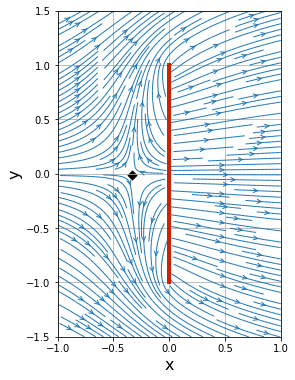

In [11]:
# рисуем линии тока
size = 4
pyplot.figure(figsize=(size, (y_end-y_start)/(x_end-x_start)*size))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.streamplot(X, Y, u, v,
                  density=2, linewidth=1, arrowsize=1, arrowstyle='->')
# рисуем слой источников
pyplot.axvline(0.0,
               (y_min-y_start)/(y_end-y_start),
               (y_max-y_start)/(y_end-y_start),
               color='#CD2305', linewidth=4)
# вычисляем величину скорости и индексы точки торможения
# внимание: за точку торможения принимается точка,
# в которой скорость минимальна
magnitude = numpy.sqrt(u**2 + v**2)
j_stagn, i_stagn = numpy.unravel_index(magnitude.argmin(),\
                                       magnitude.shape)
# рисуем точку торможения
pyplot.scatter(x[i_stagn], y[j_stagn],
               color='black', s=40, marker='D')
pyplot.xlim(x_start, x_end)
pyplot.ylim(y_start, y_end);

Как было сказано, интенсивность $\sigma$ соответсвует расходу жидкости, вытекающей из слоя источников. Если "поиграть" с этим параметром, то можно увидеть, что при его уменьшении точка торможения становится все ближе и ближе к слою.

Чтобы использовать комбинацию нескольких слоев источников для получения обтекания тела заданной формы, нужно, чтобы каждый такой слой был частью разделительной линии тока. Возникает вопрос: *Какой должна быть интенсивность источников, чтобы так получилось?*

Объемный расход с левой стороны от слоя равен $\frac{\sigma}{2}$, и эта жидкость вытекает навстречу потоку со скоростью $U_\infty$.
Следовательно, условие непротекания требует, чтобы $\frac{\sigma}{2} = U_\infty$.

Теперь вернитесь к коду, написанному выше, и замените в нем `sigma` на правильное значение. *Где теперь точка торможения? Где проходит разделительная линия тока?*

## Дополнительные материалы

Лямбда-функции кажутся особенно запутанными, если вы только начинаете программировать на Python. Вот несколько мест, чтобы копнуть глубже эту тему:

* интересный пост, в котором рассматриваются тонкости лямбда-выражений: [Yet Another Lambda Tutorial](http://pythonconquerstheuniverse.wordpress.com/2011/08/29/lambda_tutorial/), блог "Python Conquers the Universe (29 August 2011)
* глава ["Anonymous functions: lambda"](https://www.inkling.com/read/learning-python-mark-lutz-4th/chapter-19/anonymous-functions-lambda) в книге *Learning Python* Марка Лутца.

---

In [12]:
from IPython.core.display import HTML
def css_styling():
    styles = open('../styles/custom.css', 'r').read()
    return HTML(styles)
css_styling()